# Genetik Algoritma ile Optimizasyon Projesi
## Senaryo 5: Kimya Tesisinde Reaksiyon Süresi ve Sıcaklık Ayarı

**Ad Soyad:** Ulviye Gülnihal Yüksel

**Öğrenci No:** 2312721035

**Ders:** Yapay Zeka / Optimizasyon

**GitHub Repo:** [LİNKİ BURAYA YAPIŞTIRACAKSIN]

---

### 1. Problemin Tanımı ve Senaryo Uygunluğu
Bu çalışmada, bir kimyasal üretim tesisindeki reaksiyon verimini etkileyen iki temel parametrenin (**$x_1$: Süre** ve **$x_2$: Sıcaklık**) optimize edilmesi amaçlanmıştır.

**Amaç Fonksiyonu (Verim):**
$$y = 8x_1 + 3x_2 - x_1x_2 + x_1^2$$

**Değişken Sınırları:**
* $10 \le x_1 \le 60$ (Reaksiyon Süresi - dk)
* $40 \le x_2 \le 120$ (Sıcaklık - °C)

**Sistem Kısıtları:**
1.  **Kaynak Kısıtı:** $x_1 + x_2 \le 140$
2.  **Operasyonel Kısıt:** $x_2 \ge 60$

**Çözüm Yaklaşımı:**
Problem bir maksimizasyon problemi olsa da, algoritmanın kararlılığı ve kısıt yönetimi için **"Hata Minimizasyonu" (Error Minimization)** yöntemi tercih edilmiştir. Sistemin ulaşabileceği teorik bir hedef verim belirlenmiş ve bu hedefe olan uzaklık "Hata" olarak kabul edilmiştir. Kısıt ihlalleri ise "Ceza Puanı" (Penalty) yöntemiyle fitness fonksiyonuna entegre edilmiştir.

In [18]:
import numpy as np
import random
import matplotlib.pyplot as plt

# --- PARAMETRELER VE HEDEF ---
# Hata minimizasyonu yaklaşımı için teorik bir üst sınır (Hedef) belirlenir.
HEDEF_VERIM = 660
# Kısıt ihlalinde uygulanacak ceza katsayısı
CEZA_KATSAYISI = 500

def amac_fonksiyonu(birey):
    """
    Sistemin verimini hesaplayan amaç fonksiyonu.
    y = 8x1 + 3x2 - x1x2 + x1^2
    """
    x1 = birey[0]
    x2 = birey[1]
    y = 8 * x1 + 3 * x2 - x1 * x2 + x1**2
    return y

def kisit_kontrol(birey):
    """
    Bireyin kısıtları sağlayıp sağlamadığını kontrol eder.
    İhlal durumunda 0 yerine ihlal sayısını döner (Ceza hesaplaması için).
    """
    x1, x2 = birey[0], birey[1]
    ihlaller = 0

    # 1. Değişken Sınırları (Domain Constraints)
    if not (10 <= x1 <= 60): ihlaller += 1
    if not (40 <= x2 <= 120): ihlaller += 1

    # 2. Senaryo Kısıtları
    # Kısıt A: Toplam değer 140'ı geçmemeli
    if (x1 + x2) > 140: ihlaller += 1

    # Kısıt B: Sıcaklık en az 60 olmalı
    if x2 < 60: ihlaller += 1

    return ihlaller

### 2. Genetik Algoritma Yapısı ve Operatörler

Bu çözümde kullanılan Genetik Algoritma bileşenleri, problemin sürekli  yapısına uygun olarak seçilmiştir:

* **Birey Yapısı:** $x_1$ ve $x_2$ parametrelerini içeren NumPy dizileri kullanılmıştır.
* **Uygunluk (Fitness) Fonksiyonu:** Kısıtları ihlal eden bireyleri doğrudan elemek yerine, onlara **Ceza Puanı** uygulanarak popülasyon içinde iyileşme şansı tanınmıştır.
    $$Fitness = \frac{1}{Hata + (Ceza \times Katsayı) + \epsilon}$$
* **Seçilim (Selection):** **Rank (Sıralama) Temelli Seçim** kullanılmıştır. Bu yöntem, uygunluk değerleri birbirine çok yakın olsa bile sıralama farkını koruyarak seçim baskısını dengeler.
* **Çaprazlama (Crossover):** Değişkenlerin bütünlüğünü korumak adına **Tek Noktalı (Swap) Çaprazlama** uygulanmıştır.
* **Mutasyon:** Sayısal optimizasyon olduğu için **Gaussian (Normal Dağılım) Mutasyon** tercih edilmiştir. Bu, bireyin mevcut konumundan çok uzaklaşmadan ince ayar yapmasını sağlar.

In [19]:
def uygunluk_hesapla(birey):
    """
    Fitness fonksiyonu: Hedef verime ne kadar yakınsa ve
    kısıtları ne kadar az ihlal ediyorsa fitness o kadar yüksek olur.
    """
    y_verim = amac_fonksiyonu(birey)
    ceza_puani = kisit_kontrol(birey) * CEZA_KATSAYISI

    # Hata = Hedef - Gerçekleşen (Negatif olmaması için max(0, ...))
    hata = max(0, HEDEF_VERIM - y_verim)

    # Paydanın 0 olmaması için 1e-6 eklenir
    fitness = 1 / (hata + ceza_puani + 1e-6)
    return fitness

def populasyon_olustur(boyut):
    """Başlangıç popülasyonunu rastgele değerlerle üretir."""
    pop = []
    for _ in range(boyut):
        x1 = np.random.uniform(10, 60)
        x2 = np.random.uniform(40, 120)
        pop.append([x1, x2])
    return np.array(pop)

def rank_temelli_secim(populasyon, uygunluklar):
    """
    Rank Selection: Bireyleri fitness değerlerine göre sıralar ve
    sıralama puanına göre seçim yapar.
    """
    N = len(populasyon)
    sirali_indeksler = np.argsort(uygunluklar) # Küçükten büyüğe indeksler

    # Sıralama puanı (Rank): En kötüye 1, en iyiye N puan
    rank_degerleri = np.arange(1, N + 1)
    rank_toplami = np.sum(rank_degerleri)

    # Seçilme olasılıkları
    olasiliklar = rank_degerleri / rank_toplami

    # Olasılıklara göre 2 ebeveyn seç
    secilen_indeksler = np.random.choice(N, size=2, p=olasiliklar, replace=False)

    # Orijinal popülasyondan bireyleri getir
    orijinal_indeksler = sirali_indeksler[secilen_indeksler]
    return populasyon[orijinal_indeksler[0]], populasyon[orijinal_indeksler[1]]

def tek_noktali_caprazlama(e1, e2):
    """Gen Takası (Swap): Değişkenleri ebeveynler arasında takas eder."""
    c1 = e1.copy()
    c2 = e2.copy()

    # %50 ihtimalle x2 genini takas et
    if random.random() < 0.5:
        c1[1], c2[1] = c2[1], c1[1]

    return c1, c2

def mutasyon(birey, oran=0.1):
    """Gaussian Mutasyon: Mevcut değere normal dağılımlı gürültü ekler."""
    mutant = birey.copy()

    # x1 için mutasyon (Standart sapma daha düşük tutuldu)
    if random.random() < oran:
        mutant[0] += np.random.normal(0, 2.0)
        mutant[0] = np.clip(mutant[0], 10, 60) # Sınır kontrolü

    # x2 için mutasyon (Sıcaklık aralığı geniş olduğu için std yüksek)
    if random.random() < oran:
        mutant[1] += np.random.normal(0, 5.0)
        mutant[1] = np.clip(mutant[1], 40, 120) # Sınır kontrolü

    return mutant

### 3. Algoritmanın Koşulması (Evolution Engine)

Algoritma belirlenen nesil sayısı boyunca çalıştırılır. Her nesilde:
1.  Bireylerin uygunlukları hesaplanır.
2.  **Elitizm** uygulanarak en iyi birey bozulmadan bir sonraki nesle aktarılır.
3.  Rank seçimi, çaprazlama ve mutasyon ile yeni bireyler üretilir.
4.  Süreç boyunca en iyi fitness ve gerçek verim değerleri grafik çizimi için kaydedilir.

In [20]:
def ga_calistir():
    # Parametreler
    POP_BOYUTU = 50
    NESIL_SAYISI = 100
    MUTASYON_ORANI = 0.2

    # Başlangıç
    populasyon = populasyon_olustur(POP_BOYUTU)
    takip_fitness = []
    takip_verim = []

    print(f"Genetik Algoritma Başlatılıyor... (Hedeflenen Verim: {HEDEF_VERIM})")

    for i in range(NESIL_SAYISI):
        # 1. Uygunluk Hesaplama
        uygunluklar = np.array([uygunluk_hesapla(b) for b in populasyon])

        # 2. En İyi Bireyi Kaydetme (Elitizm için)
        en_iyi_idx = np.argmax(uygunluklar)
        en_iyi_birey = populasyon[en_iyi_idx].copy()

        # İstatistikler
        en_iyi_fit = uygunluklar[en_iyi_idx]
        gercek_verim = amac_fonksiyonu(en_iyi_birey)
        takip_fitness.append(en_iyi_fit)
        takip_verim.append(gercek_verim)

        # 3. Yeni Nesil (Elitizm: En iyiyi direkt al)
        yeni_pop = [en_iyi_birey]

        while len(yeni_pop) < POP_BOYUTU:
            # Seçim
            anne, baba = rank_temelli_secim(populasyon, uygunluklar)
            # Çaprazlama
            cocuk1, cocuk2 = tek_noktali_caprazlama(anne, baba)
            # Mutasyon
            cocuk1 = mutasyon(cocuk1, MUTASYON_ORANI)
            cocuk2 = mutasyon(cocuk2, MUTASYON_ORANI)

            yeni_pop.extend([cocuk1, cocuk2])

        # Popülasyon güncelleme
        populasyon = np.array(yeni_pop[:POP_BOYUTU])

        # Periyodik Bilgi
        if (i+1) % 20 == 0:
            durum = "Geçerli" if kisit_kontrol(en_iyi_birey) == 0 else "İHLAL"
            print(f"Nesil {i+1}: Verim = {gercek_verim:.2f} | Durum: {durum}")

    return en_iyi_birey, takip_fitness, takip_verim

# Algoritmayı Çalıştır
en_iyi_birey, history_fit, history_yield = ga_calistir()

Genetik Algoritma Başlatılıyor... (Hedeflenen Verim: 660)
Nesil 20: Verim = 654.35 | Durum: Geçerli
Nesil 40: Verim = 659.06 | Durum: Geçerli
Nesil 60: Verim = 659.06 | Durum: Geçerli
Nesil 80: Verim = 659.06 | Durum: Geçerli
Nesil 100: Verim = 659.06 | Durum: Geçerli


### 4. Sonuçların Görselleştirilmesi ve Analiz

Algoritmanın performansı iki farklı grafik ile analiz edilmiştir:
1.  **Fitness Grafiği:** Hata minimizasyonuna dayalı uygunluk değerinin artışını gösterir.
2.  **Gerçek Verim Grafiği:** Problemin fiziksel karşılığı olan $y$ değerinin (reaksiyon verimi) nesiller boyunca nasıl maksimize edildiğini gösterir.

**Kısıt Kontrolü:** Sonuçların $x_1 + x_2 \le 140$ ve $x_2 \ge 60$ kısıtlarına uygunluğu nihai olarak doğrulanır.


=== OPTİMİZASYON SONUÇLARI ===
En İyi Reaksiyon Süresi (x1): 60.00 dk
En İyi Sıcaklık (x2)        : 60.02 °C
Maksimum Verim (y)          : 659.06
Kısıt İhlal Sayısı          : 0


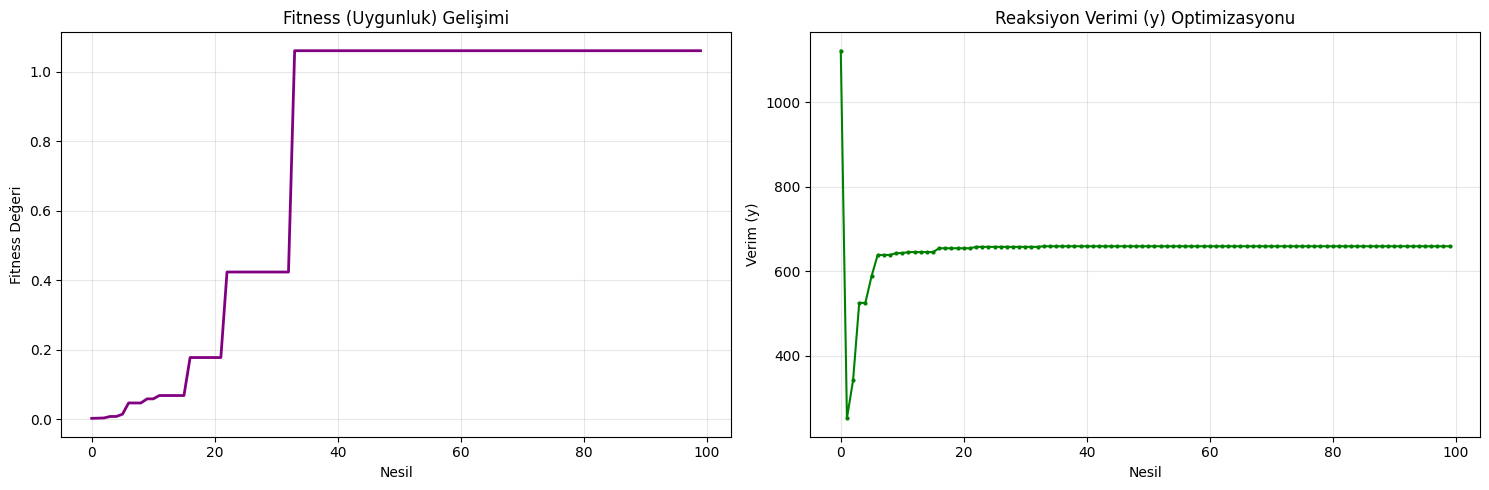

In [21]:
print("\n" + "="*40)
print("=== OPTİMİZASYON SONUÇLARI ===")
print(f"En İyi Reaksiyon Süresi (x1): {en_iyi_birey[0]:.2f} dk")
print(f"En İyi Sıcaklık (x2)        : {en_iyi_birey[1]:.2f} °C")
print(f"Maksimum Verim (y)          : {amac_fonksiyonu(en_iyi_birey):.2f}")
print(f"Kısıt İhlal Sayısı          : {kisit_kontrol(en_iyi_birey)}")
print("="*40)

# Grafik Çizimi
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# Sol Grafik: Fitness Gelişimi
ax[0].plot(history_fit, color='purple', linewidth=2)
ax[0].set_title('Fitness (Uygunluk) Gelişimi')
ax[0].set_xlabel('Nesil')
ax[0].set_ylabel('Fitness Değeri')
ax[0].grid(True, alpha=0.3)

# Sağ Grafik: Gerçek Verim Gelişimi
ax[1].plot(history_yield, color='green', marker='.', markersize=4)
ax[1].set_title('Reaksiyon Verimi (y) Optimizasyonu')
ax[1].set_xlabel('Nesil')
ax[1].set_ylabel('Verim (y)')
ax[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()